![Tux, the Linux mascot](kuzushiji-strips.jpg)

# Classifying handwritten characters in ancient Japanese manuscripts

In [3]:
%matplotlib inline

In [4]:
import os
import multiprocessing
import concurrent.futures
from itertools import repeat
import time
import dill
from datetime import datetime

from IPython.display import clear_output

import workers
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import ImageCollection, imshow_collection, imshow
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.morphology import binary_closing
from skimage.transform import resize

from scipy import sparse

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report


/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [3]:
np.random.seed(123123)

> Recorded historical documents give us a peek into the past. We are able to glimpse the world before our time; and see its culture, norms, and values to reflect on our own. Japan has very unique historical pathway. Historically, Japan and its culture was relatively isolated from the West, until the Meiji restoration in 1868 where Japanese leaders reformed its education system to modernize its culture. This caused drastic changes in the Japanese language, writing and printing systems. Due to the modernization of Japanese language in this era, cursive Kuzushiji (くずし字) script is no longer taught in the official school curriculum.

And to this day, hundreds of thousands of books and texts, written in Kuzushiji, remain unreadable for the vast majority of modern Japanese natives. It really is a shame, given how much of their history is contained in those documents. Most of them have been digitized but have never been transcribed, and can only currently be read by a few experts.

The [dataset](https://www.kaggle.com/c/kuzushiji-recognition/overview) is taken from a Kaggle competition with the same objective. 

## 1. Data acquisition

We have two main datasets - one containing the raw images and one for their labels. Let's read them into a collection.

In [4]:
raw_train_images = ImageCollection('train_images/*.jpg')

In [5]:
len(raw_train_images)

3605

As we can see, we have a total of 3605 images. Let's take a look at one of them.

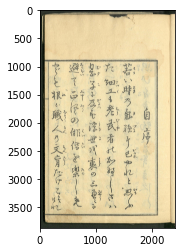

In [6]:
plt.imshow(raw_train_images[0])
plt.show()

For the moment we will leave this array as is and focus on the labeling data.

In [7]:
raw_train_labels = pd.read_csv("labels.csv")
raw_train_labels.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


## 2. Data Tidying and Cleaning

As we can see, there are two columns. The first (`image_id`) contains the filename of the image, which the labels are for. The second one stores all the labels in a certain format. From the documentation, we know that each label contains five components: `Unicode character`, `X`, `Y`, `width` and `height` of the box, separated by intervals.

In [8]:
# Split every string before every new unicode character label.
raw_train_labels.labels = raw_train_labels.labels.str.split(pat=r" (?=U)")

Using the pandas `explode` method we transform every list of labels into different rows, preserving each label's `image_id`.

In [9]:
separated_train_labels = raw_train_labels.explode("labels")
separated_train_labels.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53
0,100241706_00004_2,U+304C 275 1652 84 69
0,100241706_00004_2,U+3044 1495 1218 143 69
0,100241706_00004_2,U+3051 220 3331 53 91
0,100241706_00004_2,U+306B 911 1452 61 92


So now let's split the `labels` column into the 5 different variables it actually keeps track off.

In [10]:
labels_data_splitted = separated_train_labels.labels.str.split(expand=True)

labels_data_splitted.head()

,0,1,2,3,4
0,U+306F,1231,3465,133,53
0,U+304C,275,1652,84,69
0,U+3044,1495,1218,143,69
0,U+3051,220,3331,53,91
0,U+306B,911,1452,61,92


Let's convert the last four variables into integers.

In [11]:
for col_index in range(1, 5):
    labels_data_splitted[col_index] = labels_data_splitted[col_index].astype(int)
    
labels_data_splitted.dtypes

0    object
1     int64
2     int64
3     int64
4     int64
dtype: object

We no longer need the labels column, so we can safely remove it. 

In [12]:
separated_train_labels = separated_train_labels.drop("labels", axis=1)

Now let's join the two dataframes - the first one, containing the image ids and the second one, containing the label data.

In [13]:
separated_train_labels = pd.concat([separated_train_labels, labels_data_splitted], axis=1)

In [14]:
separated_train_labels.columns = ["image_id", "unicode_char", "x", "y", "width", "height"]
separated_train_labels.head()

,image_id,unicode_char,x,y,width,height
0,100241706_00004_2,U+306F,1231,3465,133,53
0,100241706_00004_2,U+304C,275,1652,84,69
0,100241706_00004_2,U+3044,1495,1218,143,69
0,100241706_00004_2,U+3051,220,3331,53,91
0,100241706_00004_2,U+306B,911,1452,61,92


We have now a dataframe with each different labeled image fragment in a different row. 

Now let's put all the image ids (which we extract from their filenames) in a list, in the order of which they appear.

In [15]:
image_ids = os.listdir('train_images')
image_ids[:10]

['100241706_00004_2.jpg',
 '100241706_00005_1.jpg',
 '100241706_00005_2.jpg',
 '100241706_00006_1.jpg',
 '100241706_00007_2.jpg',
 '100241706_00008_1.jpg',
 '100241706_00008_2.jpg',
 '100241706_00009_1.jpg',
 '100241706_00009_2.jpg',
 '100241706_00010_1.jpg']

So next up we can split our problem into two main parts:
    1. First when we receive a new image, we want to extract all the different kuzushiji characters from it.
    2. Only after that we can identify them.

For this project, we will only focus on the second task and use the data which already has the character bounds identified.

The next step in our data preparation consists of extracting only the parts of the images which we have labels for. Let's create a function, which takes the crop data about an image, based on which returns the new cropped extract.

In [16]:
def crop_image(crop_data, image_ids, raw_train_images):
    image_index = image_ids.index(f"{crop_data.image_id}.jpg")
    img_to_crop = raw_train_images[image_index]
    return img_to_crop[crop_data.y : crop_data.y + crop_data.height, crop_data.x : crop_data.x + crop_data.width]

Now let's test the crop function on the first set of labeled data from the `separated_train_labels` dataframe.

In [17]:
crop_data = separated_train_labels.iloc[2]
first_kuzushiji = crop_image(crop_data, image_ids, raw_train_images)

Next we need to plot the result.

In [18]:
def plot_image_large(image, cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.show()

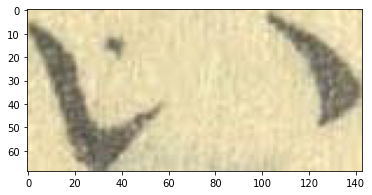

In [19]:
plot_image_large(first_kuzushiji)

As we can see the kuzushiji segments consist of two parts - the actual kuzushiji and the background. That means that color is irrelevant and we can safely even use basic binary images.
First let's convert the image to grayscale and look at it's histogram.

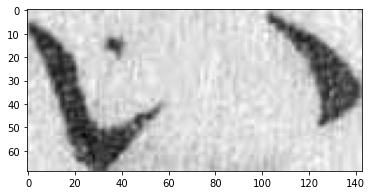

In [20]:
first_kuzushiji_gray = rgb2gray(first_kuzushiji)
plot_image_large(first_kuzushiji_gray, cmap="gray")

In [21]:
def plot_hist_image(image):
    plt.hist(image.ravel(), bins=256)
    plt.title('Histogram')
    plt.show()

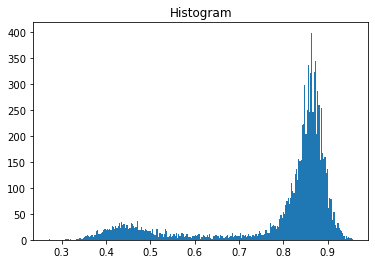

In [22]:
plot_hist_image(first_kuzushiji_gray)

It is obvious that the character and the background are clearly separated. This is why we can use a threshold value and convert the image into a binary one.

Let's see what is the threshold value based on Otsu’s method.

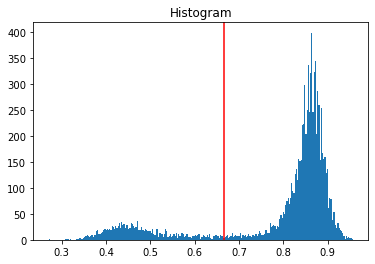

In [23]:
plt.axvline(threshold_otsu(first_kuzushiji_gray), color="r")
plot_hist_image(first_kuzushiji_gray)

Scikit-image provides multiple different thresholding algorithms. And a very convenient function `try_all_threshold`, used to compare their results and help us choose a method, which works best with our data.

In [24]:
def plot_all_threshold(image):
    plt.figure(figsize=(3,3))
        
    # Display original image
    plt.imshow(image)
    
    # Display grayscale image and binary image, using every method for thresholding
    image_gray = rgb2gray(image)
    fig, ax = try_all_threshold(image_gray, figsize=(3, 4), verbose=False)
    
    plt.show()

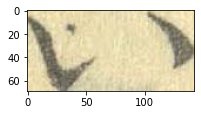

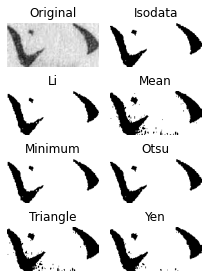

In [25]:
plot_all_threshold(first_kuzushiji)

Let's look at a few more examples, so that we can decide more easily.

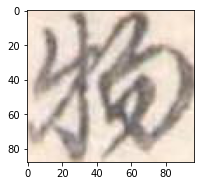

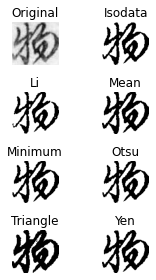

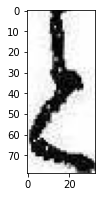

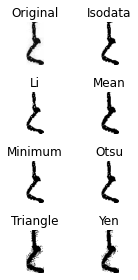

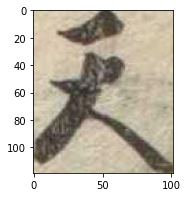

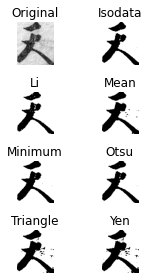

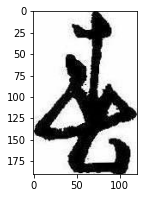

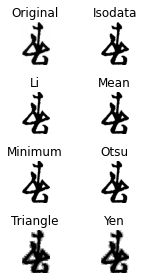

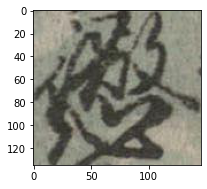

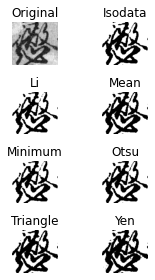

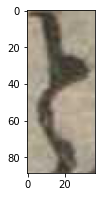

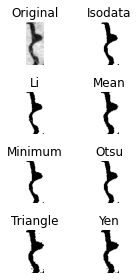

In [26]:
sample_amount = 6
np.random.seed(2323)

for i in range(1, sample_amount + 1):
    # Select a random index and get the labeled sector
    index_image = np.random.randint(0, len(separated_train_labels))
    crop_data = separated_train_labels.iloc[index_image]
    
    # Extract the labeled sector from the whole image
    curr_kuzushiji = crop_image(crop_data, image_ids, raw_train_images)
    
    plot_all_threshold(curr_kuzushiji)

We can see that the Isodata and Otsu methods work equally great for our data. The Otsu method generally presents the best Sensitivity and Specificity, which is why we are going to choose it for our project.

In [27]:
def thresh_image(image):
    thresh = threshold_otsu(image)
    
    # Get only the pixels which are over the threshold
    binary = image > thresh
    
    # We get 1 - binary, because we want the "important" kuzushiji pixels to have 1 as a value.
    return 1 - binary

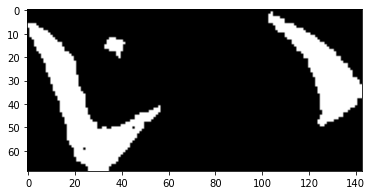

In [28]:
first_kuzushiji_binary = thresh_image(first_kuzushiji_gray)
plot_image_large(first_kuzushiji_binary, cmap="gray")

Let's look at how some of the thresholded images. 

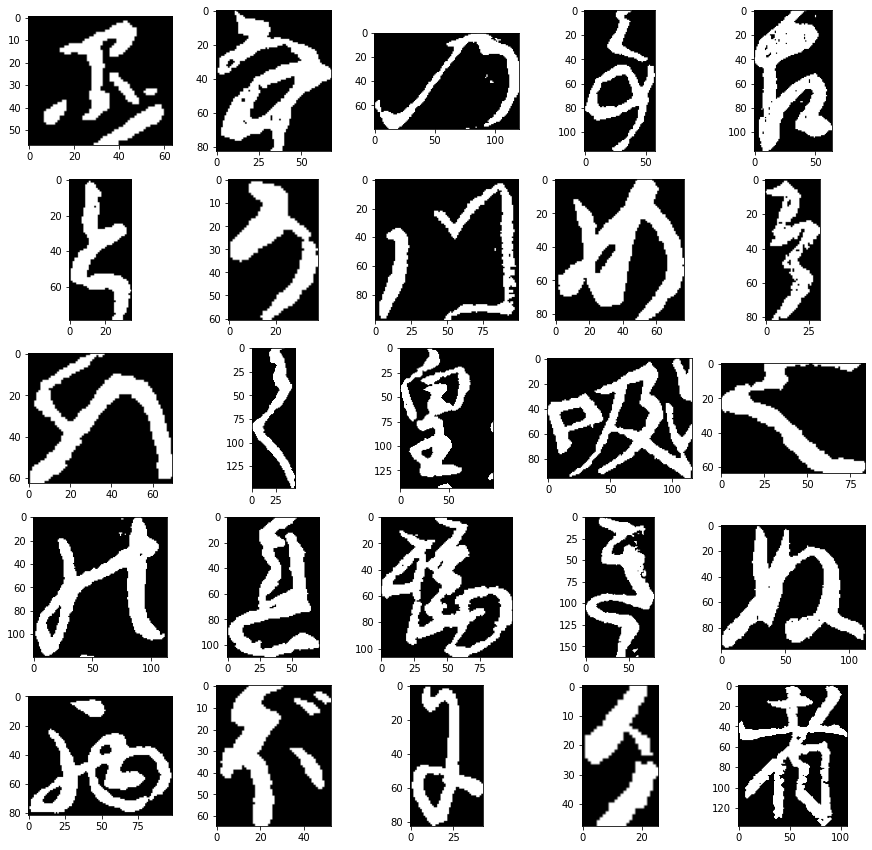

In [29]:
def get_random_gray_segment(): 
    # Select a random index and get the labeled sector
    index_image = np.random.randint(0, len(separated_train_labels))
    crop_data = separated_train_labels.iloc[index_image]
    
    # Extract the labeled segment from the whole image
    curr_kuzushiji = crop_image(crop_data, image_ids, raw_train_images)
    
    curr_kuzushiji_gray = rgb2gray(curr_kuzushiji)
    return curr_kuzushiji_gray

def subplot_binary_image(rows, cols, i, image):
    plt.subplot(rows, cols, i)
    plt.imshow(image, cmap="gray")

rows, cols = 5, 5
sample_amount = rows * cols

plt.figure(figsize=(3 * cols, 3 * rows))
for i in range(1, sample_amount + 1):
    curr_kuzushiji_gray = get_random_gray_segment()
    
    curr_kuzushiji_binary = thresh_image(curr_kuzushiji_gray)
    
    subplot_binary_image(rows, cols, i, curr_kuzushiji_binary)
    
plt.show()

As we can see most of the images have small "holes", which can be fixed using image morphology, or more specifically - binary closing (dilation, followed by erosion).

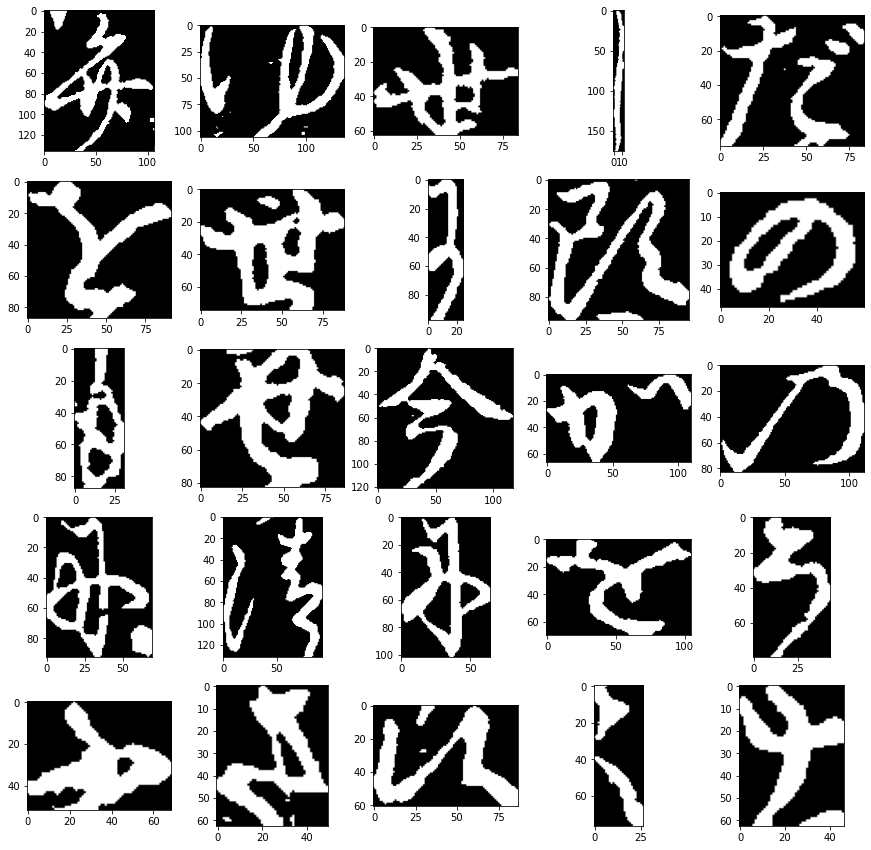

In [30]:
plt.figure(figsize=(15, 15))
for i in range(1, sample_amount + 1):
    curr_kuzushiji_gray = get_random_gray_segment()
    
    curr_kuzushiji_binary = binary_closing(thresh_image(curr_kuzushiji_gray))
    
    subplot_binary_image(rows, cols, i, curr_kuzushiji_binary)
    
plt.show()

Next, let's take a quick look at the distribution of the classes throughout the dataset.

In [31]:
def analyze_distribution():
    vals = [1, 2, 3, 5, 10, 20, 50 , 100]
    for i in vals:
        classes_counts = (separated_train_labels.unicode_char.value_counts() < i + 1)
        num_values = len(classes_counts) - classes_counts.value_counts()[False]
        print(f"Classes with less than {i + 1} images = {num_values}")
    print(f"Total classes = {len(separated_train_labels.unicode_char.unique())}")
    print(separated_train_labels.unicode_char.value_counts().describe())

analyze_distribution()

Classes with less than 2 images = 790
Classes with less than 3 images = 1185
Classes with less than 4 images = 1433
Classes with less than 6 images = 1793
Classes with less than 11 images = 2273
Classes with less than 21 images = 2692
Classes with less than 51 images = 3235
Classes with less than 101 images = 3591
Total classes = 4212
count     4212.000000
mean       162.265907
std       1106.475303
min          1.000000
25%          2.000000
50%          9.000000
75%         44.000000
max      24685.000000
Name: unicode_char, dtype: float64


As we can see, the frequency distribution is very long-tailed and a large fraction of the characters only appear once or twice in our dataset. These kuzushijis are actually Kanji (a japanese hieroglyph for a whole word), which has a very specific meaning. And also the median of the value counts is only 9, which is not very good for us. For now we can maybe try and duplicate all the records for classes with below 5 images. This way later we will be able to take a stratified sample of the data, which would previously be impossible, given that 800 of the images have only 1 record.

In [32]:
imbalanced_data_index = (separated_train_labels.unicode_char.value_counts() <= 5)
under_represented_classes = separated_train_labels.unicode_char.value_counts()[imbalanced_data_index].index
oversampled_values = separated_train_labels[separated_train_labels.unicode_char.isin(under_represented_classes)]

separated_train_labels = separated_train_labels.append(oversampled_values)

In [33]:
analyze_distribution()

Classes with less than 2 images = 0
Classes with less than 3 images = 790
Classes with less than 4 images = 790
Classes with less than 6 images = 1185
Classes with less than 11 images = 2273
Classes with less than 21 images = 2692
Classes with less than 51 images = 3235
Classes with less than 101 images = 3591
Total classes = 4212
count     4212.000000
mean       163.195632
std       1106.342303
min          2.000000
25%          4.000000
50%         10.000000
75%         44.000000
max      24685.000000
Name: unicode_char, dtype: float64


Now we have at least two samples for each class. We will later see if further oversampling is needed.

Our dataset is really large. Around 4200 classes spread out over more than 683000 images. But before we use some more advanced dimensionality reduction techniques to tackle that, we need to resize all of the images, so that they have the same dimensions.

Downsizing larger images to match the size of smaller images is often a better bet than increasing the size of small images to be larger. If we increase small images to be larger, we stretch small image pixels. This can obscure our model’s ability to learn key features in the different objects.

So let's look at the two columns to our dataset (the full one, not the sample), describing the dimensions of each image.

In [34]:
def plot_dim_data(dim_data, dim):
    dim_data_desc = pd.DataFrame(dim_data.describe(percentiles = [.25, .5, .75]))[dim]
    print(f"{dim}: \n{dim_data_desc}\n\n")

    plt.hist(dim_data, bins=150)
    plt.axvline(x=dim_data_desc["mean"], c="red")
    plt.axvline(x=dim_data_desc["75%"], c="green")
    plt.title(dim)
    plt.xlabel("pixels")
    plt.ylabel("images")
    plt.show()

width: 
count    687380.000000
mean         77.360755
std          30.507641
min           6.000000
25%          55.000000
50%          77.000000
75%          96.000000
max         520.000000
Name: width, dtype: float64




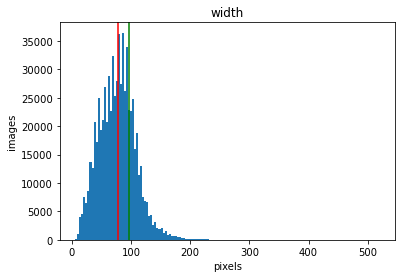

height: 
count    687380.000000
mean         95.044150
std          34.513275
min           5.000000
25%          72.000000
50%          91.000000
75%         112.000000
max         993.000000
Name: height, dtype: float64




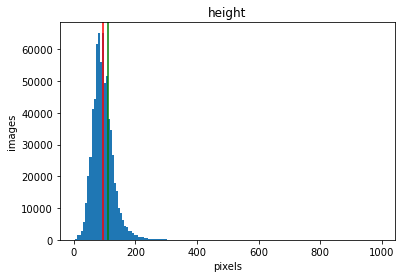

In [35]:
plot_dim_data(separated_train_labels.width, "width")
plot_dim_data(separated_train_labels.height, "height")

In our case the 75th percentile includes the most data, while being still relatively close to the mean value. But we already have a very large dataset, and if we take this approach, most of the images will have to be upscaled. So let's take the 25th percentile dimensions as our standard, which we will resize our images to. They are: `55px x 70px`. The `skimage` library provides a convenient `resize` method for us.

In [36]:
WIDTH = 55
HEIGHT = 70
DIMENSIONS = (HEIGHT, WIDTH)

Before we test how all our manipulations work together, let's create a function, which applies them, given only the segment coordinates, label and the image, from which it needs to extract it from.

In [37]:
def prepare_segment(segment_data, image_ids, raw_train_images, width, height):
    '''
    Extracts the segment based on the provided data, given the raw images. 
    After that it resizes it to be with dimensions (height, width).
    At the end it converts it to a binary image and preforms binary closing on it.

            Parameters:
                    segment_data (dict): The segment data in the format:
                        {
                            image_id: string,
                            unicode_char: string,
                            x: int,
                            y: int,
                            width: int,
                            height: int
                        }
                    image_ids: A list of image ids, which is used to find the index of the given image, 
                        using it's image_id
                    raw_train_images: A list of the raw images
                    width: The width which we will resize our segment to.
                    height: The height which we will resize our segment to.

            Returns:
                    extracted_kuzushiji_binary_closed (np.ndarray): The extracted binary segment.
    '''
    
    extracted_kuzushiji = crop_image(segment_data, image_ids, raw_train_images)
    
    extracted_kuzushiji = resize(extracted_kuzushiji, (height, width))
    
    extracted_kuzushiji_gray = rgb2gray(extracted_kuzushiji)
    
    extracted_kuzushiji_binary = thresh_image(extracted_kuzushiji_gray)
    
    extracted_kuzushiji_binary_closed = binary_closing(extracted_kuzushiji_binary).astype(int)
    
    return extracted_kuzushiji_binary_closed

In [38]:
len(separated_train_labels)

687380

We see that we have a lot of records to manipulate. So before we do that, let's test everything we've done so far on a small amount of the segments.

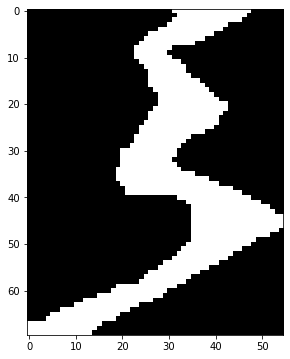

In [39]:
small_sample_iter = separated_train_labels.sample(50, random_state=55).iterrows()

for index, row in small_sample_iter:
    im = prepare_segment(row, image_ids, raw_train_images, WIDTH, HEIGHT)

    plot_image_large(im, cmap="gray")    
    clear_output(wait=True)

We can see that our function `prepare_segment` works as expected.

Let's create a new dataframe, storing the binary images with their labels. To save time, I will create multiple processes, which will utilize multiple of our CPU cores. In order to do that I will have to split the raw image and labels data (`separated_train_labels`) into multiple chunks. Below this is the function which will take as arguments chunk (array) of labeled image entries  (`chunk`), the image ids (`image_ids`) and the raw images (`raw_train_images`), from which we will crop the segments. It will then do the necessary manipulations and return a list with the results in the end. Lets first test the method on a small stratified amount of the data using a stratified 10% sample, on which it would be easier to perform farther analysis on. 

In [40]:
def convert_chunk(chunk, image_ids, raw_train_images, width, height):
    row_list = []

    for _, row in chunk.iterrows():
        im = prepare_segment(row, image_ids, raw_train_images, width, height)

        new_data = {
            "image": im,
            "label": row.unicode_char,
            "width": width,
            "height": height
        }
        row_list.append(new_data) 
        
    return row_list

In [42]:
print("Preparing chunks")

separated_train_labels_sample, _ = train_test_split(separated_train_labels, train_size=0.1, stratify=separated_train_labels["unicode_char"])
chunks = np.array_split(separated_train_labels_sample, 10)

print(len(separated_train_labels_sample), "observations")

Preparing chunks
68738 observations


In [45]:
NUM_PROCESSORS = None
statuses = []

if __name__ ==  '__main__': 
    with concurrent.futures.ProcessPoolExecutor(max_workers=NUM_PROCESSORS) as pool:
        print(f"Starting manipulations - {datetime.now().__str__()}")
        start = time.perf_counter()
        
        returned_future = pool.map(convert_chunk, 
                                   chunks, 
                                   repeat(image_ids), 
                                   repeat(raw_train_images), 
                                   repeat(WIDTH), 
                                   repeat(HEIGHT))
        
        output = []
        for returned_chunk in returned_future:
            output.append(returned_chunk)
        
        finish = time.perf_counter()
  
        print(f"Finished in {round(finish - start, 2)} second(s) - {datetime.now().__str__()}")

Creating pool
Starting manipulations
Finished in 9993.4 second(s)


So now let's join our chunks back together and convert them into a new sample dataframe.

In [47]:
result = np.array(output[0])
for chnk in output[1:]:
    result = np.concatenate((result, np.array(chnk)))
    
print(result.shape)
segmented_binary_sample = pd.json_normalize(result)

(68738, 4)


In [45]:
segmented_binary_sample.head()

,image,label,width,height
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",U+3031,55,70
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",U+307C,55,70
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",U+767D,55,70
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",U+5BA2,55,70
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",U+53BB,55,70


In [46]:
len(segmented_binary_sample)

68738

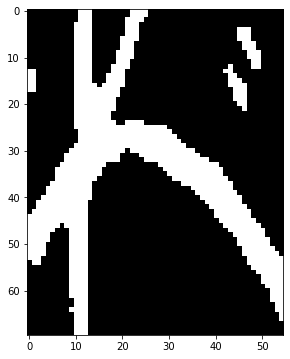

In [47]:
plot_image_large(segmented_binary_sample.sample(1).iloc[0].image.reshape(HEIGHT, WIDTH), cmap="gray")

We can see (by the above sample image), that our extraction was successful.

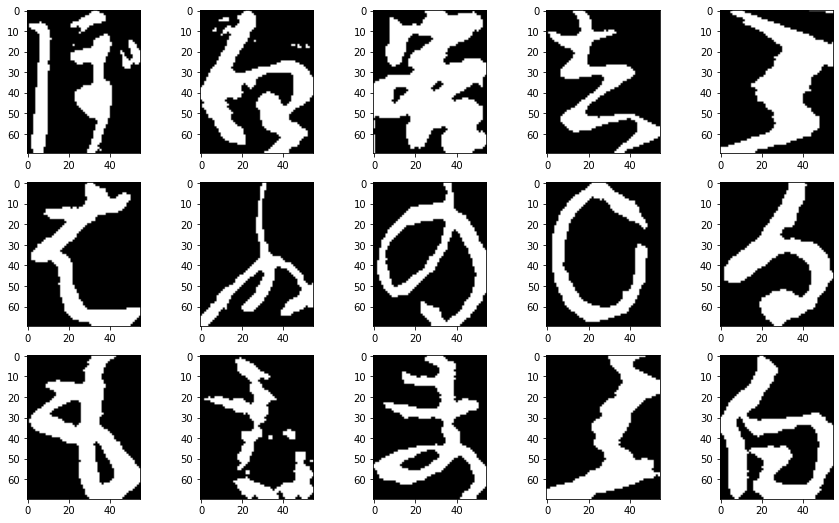

In [48]:
rows, cols = 3, 5
sample_amount = rows * cols

plt.figure(figsize=(3 * cols, 3 * rows))
for i in range(1, sample_amount + 1):
    curr_kuzushiji = segmented_binary_sample.iloc[i].image.reshape(HEIGHT, WIDTH)
    subplot_binary_image(rows, cols, i, curr_kuzushiji)
    
plt.show()

All the images appear to be the same size, so the resizing was also successful.

Now that we are done visualizing and working on the raw images, it is time, that we put them in a dataframe, where each pixel is a separate feature.

In [49]:
segmented_binary_sample.image = segmented_binary_sample.image.apply(np.ravel)
segmented_binary_sample_images = segmented_binary_sample.image
segmented_binary_sample_labels = segmented_binary_sample.label
start = time.perf_counter()
segmented_binary_sample_images = pd.DataFrame(segmented_binary_sample_images.values.tolist(), 
                                              index=segmented_binary_sample_images.index)
finish = time.perf_counter()

print(f"Finished in {round(finish - start, 2)} second(s)")

Finished in 932.3 second(s)


In [49]:
segmented_binary_sample_images.head()

,0,1,2,3,4,5,6,7,8,9,...,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So now let's try applying linear PCA on our images, to see if we can preform some sort of dimensionality reduction on them.

In [56]:
linear_pca = PCA()

start = time.perf_counter()

linear_pca.fit(segmented_binary_sample_images)

finish = time.perf_counter()

print(f"Finished in {round(finish - start, 2)} second(s)")

Finished in 79.4 second(s)


In [50]:
linear_pca.explained_variance_ratio_

array([5.02444283e-02, 3.69825009e-02, 3.39359251e-02, ...,
       2.52751529e-06, 2.42417502e-06, 2.33149806e-06])

In [51]:
linear_pca.explained_variance_ratio_[::-1].cumsum()

array([2.33149806e-06, 4.75567308e-06, 7.28318837e-06, ...,
       9.12773071e-01, 9.49755572e-01, 1.00000000e+00])

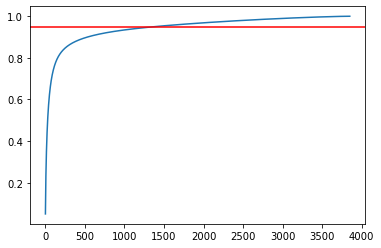

In [53]:
plt.plot(linear_pca.explained_variance_ratio_.cumsum())
plt.axhline(y = 0.95, c = "r")
plt.show()

As we can see the explained variance ratio is kind of low and if we want to preserve 95% of the variance, we would have to take around 1500 components. That is why we can maybe try applying PCA on the whole dataset for better results. But first we need to extract the segments for the whole dataset.

This time the data which we will be recieving from every separate process will be too large to then return to the main python script. That is why we will do something different. After each process is done, we will save it's data in an external binary file and then later load it back right into python.

In [56]:
# with open(f'./segmented_binary_kuzushijis_whole.db', 'wb') as pickle_file:
#     dill.dump(segmented_binary_kuzushijis, pickle_file)

with open(f'./segmented_binary_kuzushijis_whole.db', 'rb') as pickle_file:
    segmented_binary_kuzushijis = dill.load(pickle_file)

# with open(f'./segmented_binary_kuzushijis_images_nd.db', 'wb') as pickle_file:
#     dill.dump(, pickle_file)

# with open(f'./segmented_binary_sample.db', 'rb') as pickle_file:
#     segmented_binary_sample = dill.load(pickle_file)

# with open(f'./segmented_binary_sample_images.db', 'rb') as pickle_file:
#     segmented_binary_sample_images = dill.load(pickle_file)

# with open(f'./segmented_binary_sample_labels.db', 'rb') as pickle_file:
#     segmented_binary_sample_labels = dill.load(pickle_file)
    
# with open(f'./linear_pca.db', 'rb') as pickle_file:
#     linear_pca = dill.load(pickle_file)

Let's create a wrapper around our `convert_chunk` function, which will export the converted images into a new file.  

In [164]:
def convert_chunk_to_file(chunk, image_ids, raw_train_images, width, height, chunk_id):
    row_list = convert_chunk(chunk, image_ids, raw_train_images, width, height)

    print(f"Finished working on {chunk_id} data with {len(row_list)} observations.")
    
    with open(f'../segmented_binary_kuzushijis/chunk_{chunk_id}.db', 'wb') as pickle_file:
        dill.dump(pd.json_normalize(row_list), pickle_file)

    print(f"Saved data to file: './chunk_{chunk_id}.db'")
    return 'ok'

We now need to split our train labels into 10 different chunks.

In [162]:
print(f"Preparing chunks - {datetime.now().__str__()}")

chunks = np.array_split(separated_train_labels, 10)
chunks_indexes = np.arange(10)

print(len(np.array(chunks).flatten()) / len(chunks[0].iloc[0]), "observations")

Preparing chunks - 2021-11-18 21:47:02.606248
687380.0 observations


We finally are ready to actually start the manipulations and create 10 different processes.

In [64]:
NUM_PROCESSORS = None
statuses = []

if __name__ ==  '__main__': 
    with concurrent.futures.ProcessPoolExecutor(max_workers=NUM_PROCESSORS) as pool:
        print(f"Starting manipulations - {datetime.now().__str__()}")
        start = time.perf_counter()
        
        returned_future = pool.map(convert_chunk, 
                                   chunks, 
                                   repeat(image_ids), 
                                   repeat(raw_train_images), 
                                   repeat(WIDTH), 
                                   repeat(HEIGHT), 
                                   chunks_indexes)
        
        for returned_status in returned_future:
            statuses.append(returned_status)
        
        finish = time.perf_counter()
  
        print(f"Finished in {round(finish - start, 2)} second(s) - {datetime.now().__str__()}")

Starting manipulations - 2021-11-18 19:44:30.478373
Finished working on 9 data with 68738 observations.
Finished working on 2 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_7.db'.
Saved data to file: './segmented_binary_kuzushijis/chunk_0.db'.
Saved data to file: './segmented_binary_kuzushijis/chunk_6.db'.
Finished working on 0 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_9.db'.
Finished working on 6 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_1.db'.
Finished working on 4 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_5.db'.
Finished working on 8 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_3.db'.
Finished working on 3 data with 68738 observations.
Finished working on 7 data with 68738 observations.
Saved data to file: './segmented_binary_kuzushijis/chunk_2.db'.
Saved data to file: 

After this is done, we extract the dataframes from the files, which we just created and join them all together.

In [161]:
segmented_binary_kuzushijis = None
for i in chunks_indexes:
    with open(f'./segmented_binary_kuzushijis/chunk_{i}.db', 'rb') as pickle_file:
        chunk_dataframe = dill.load(pickle_file)
        if(type(segmented_binary_kuzushijis) == type(None)):
            segmented_binary_kuzushijis = chunk_dataframe
        else:
            segmented_binary_kuzushijis = segmented_binary_kuzushijis.append(chunk_dataframe)
    
segmented_binary_kuzushijis

,image,label,width,height
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+306F,55,70
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+304C,55,70
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+3044,55,70
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+3051,55,70
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+306B,55,70
...,...,...,...,...
57471,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+96F6,55,70
57472,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+8000,55,70
57473,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+30DC,55,70
57474,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+2123D,55,70


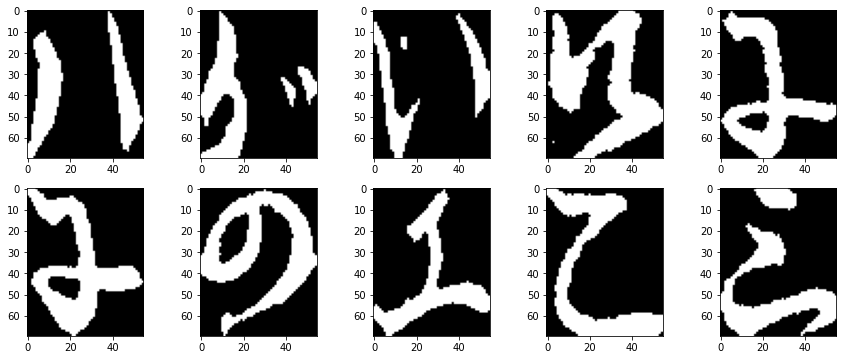

In [42]:
rows, cols = 2, 5
sample_amount = rows * cols

plt.figure(figsize=(3 * cols, 3 * rows))
for i in range(1, sample_amount + 1):
    curr_kuzushiji = segmented_binary_kuzushijis.iloc[i - 1].image
    subplot_binary_image(rows, cols, i, curr_kuzushiji)
    
plt.show()

In [43]:
segmented_binary_kuzushijis.head()

,image,label,width,height
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+306F,55,70
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+304C,55,70
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+3044,55,70
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+3051,55,70
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",U+306B,55,70


The extraction was successful, so now we can first remove the width and height columns, and after that put the images in a dataframe, where each pixel is a separate feature.

In [44]:
segmented_binary_kuzushijis.image = segmented_binary_kuzushijis.image.apply(np.ravel)

In [57]:
segmented_binary_kuzushijis_images = segmented_binary_kuzushijis.image
segmented_binary_kuzushijis_labels = segmented_binary_kuzushijis.label

We don't need to have the images in a dataframe, so we can safely just use them as a numpy binary array in order to save memory.

In [50]:
segmented_binary_kuzushijis_images = segmented_binary_kuzushijis_images.apply(lambda a: a.astype(bool))

In [51]:
segmented_binary_kuzushijis_images = segmented_binary_kuzushijis_images.values

In [52]:
segmented_binary_kuzushijis_images

array([array([False, False, False, ..., False, False, False]),
       array([False, False, False, ..., False, False, False]),
       array([False, False, False, ..., False, False, False]), ...,
       array([False, False, False, ..., False, False, False]),
       array([False, False, False, ..., False, False, False]),
       array([False, False, False, ..., False, False, False])],
      dtype=object)

The `numpy.stack` will convert our 2d numpy array into a numpy matrix of some sort.

In [53]:
segmented_binary_kuzushijis_images_nd = np.stack(segmented_binary_kuzushijis_images)

In [54]:
segmented_binary_kuzushijis_images_nd.shape

(687380, 3850)

Let's check what our data actually consists of.

In [65]:
np.unique(segmented_binary_kuzushijis_images_nd, return_counts=True)

(array([False,  True]), array([1826689355,  819723645]))

We can see that the 0's in our data (the `False` values) are around 18 billion and the 1's only 8 billion. This means that our matrix is kind of sparse. For efficency we can convert it into a sparse matrix, which is more memory efficient and easier to do calculations on.
There are several types of sparse matrices. For PCA, feature selection and dimensionality reduction, we are intersted in the Compressed Sparse Column matrix, because our variables are stored as separate columns.

In [44]:
# segmented_binary_kuzushijis_images_sparse = sparse.csc_matrix(segmented_binary_kuzushijis_images_nd)
segmented_binary_kuzushijis_images_sparse

<687380x3850 sparse matrix of type '<class 'numpy.bool_'>'
	with 819723645 stored elements in Compressed Sparse Column format>

In [51]:
# with open('./segmented_binary_kuzushijis_images_sparse.db', 'rb') as pickle_file:
#     segmented_binary_kuzushijis_images_sparse = dill.load(pickle_file)

Now let's see what PCA will give to us, using it on the whole dataset. The regular PCA algorithm doesn't support sparse input, because we will be using an alternative. Trucated SVD is very similar to the regular PCA algorithm, but it doesn't need to center the data (matrix). This means that it can accept sparse matricies without the need to densify them. To save time we will first try it out with 1500 components, to see what this will give to us.

In [45]:
truncated_svd = TruncatedSVD(n_components = 1500)

start = time.perf_counter()

truncated_svd.fit(segmented_binary_kuzushijis_images_sparse)

finish = time.perf_counter()

print(f"Finished in {round(finish - start, 2)} second(s)")

Finished in 12603.1 second(s)


In [47]:
truncated_svd.explained_variance_ratio_

array([3.85145534e-02, 4.49035239e-02, 3.48799857e-02, ...,
       2.81865636e-05, 2.81824661e-05, 2.81143695e-05])

In [48]:
truncated_svd.explained_variance_ratio_[::-1].cumsum()

array([2.81143695e-05, 5.62968357e-05, 8.44833993e-05, ...,
       8.68183203e-01, 9.13086727e-01, 9.51601280e-01])

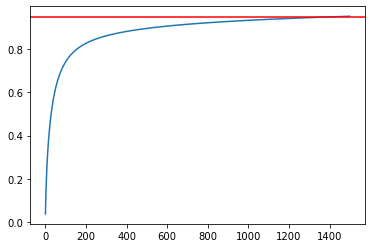

In [49]:
plt.plot(truncated_svd.explained_variance_ratio_.cumsum())
plt.axhline(y = 0.95, c = "r")
plt.show()

We can see that it performs exatly the same as PCA on our sample. This means that probably around 1300-1500 dimensions are enough.

In [54]:
segmented_binary_kuzushijis_images_reduced = truncated_svd.transform(segmented_binary_kuzushijis_images_sparse)

In [55]:
segmented_binary_kuzushijis_images_reduced.shape

(687380, 1500)

Now we can actually start trying out some basic machine learning algorihms on the data. But before that we would like to split the the data into a training and testing set. 

In [61]:
final_kuzushijis_images_train, \
final_kuzushijis_images_test, \
final_kuzushijis_labels_train, \
final_kuzushijis_labels_test = train_test_split(segmented_binary_kuzushijis_images_reduced, 
                                                segmented_binary_kuzushijis_labels, 
                                                test_size=0.2,
                                                stratify=segmented_binary_kuzushijis_labels,
                                                random_state=12)

In [6]:
sparsity = np.count_nonzero(final_kuzushijis_images_test) / final_kuzushijis_images_test.size

In [9]:
sparsity

1.0

In [6]:
# with open('./final_kuzushijis_images_train.db', 'wb') as pickle_file:
#     dill.dump(final_kuzushijis_images_train, pickle_file)
    
# with open('./final_kuzushijis_images_test.db', 'wb') as pickle_file:
#     dill.dump(final_kuzushijis_images_test, pickle_file)

# with open('./final_kuzushijis_labels_train.db', 'wb') as pickle_file:
#     dill.dump(final_kuzushijis_labels_train, pickle_file)

# with open('./final_kuzushijis_labels_test.db', 'wb') as pickle_file:
#     dill.dump(final_kuzushijis_labels_test, pickle_file)



with open('./final_kuzushijis_images_train.db', 'rb') as pickle_file:
    final_kuzushijis_images_train = dill.load(pickle_file)
    
with open('./final_kuzushijis_images_test.db', 'rb') as pickle_file:
    final_kuzushijis_images_test = dill.load(pickle_file)
    
with open('./final_kuzushijis_labels_train.db', 'rb') as pickle_file:
    final_kuzushijis_labels_train = dill.load(pickle_file)
    
with open('./final_kuzushijis_labels_test.db', 'rb') as pickle_file:
    final_kuzushijis_labels_test = dill.load(pickle_file)
    


Now that this is done, let's see how a basic descision tree describes our data.

In [15]:
decision_tree_plain = DecisionTreeClassifier()

In [8]:
final_kuzushijis_images_train_smpl, _, \
final_kuzushijis_labels_train_smpl, _ = train_test_split(final_kuzushijis_images_train, 
                                                          final_kuzushijis_labels_train, 
                                                         train_size=0.2, 
                                                         stratify=final_kuzushijis_labels_train)

In [ ]:
len(final_kuzushijis_labels_train_smpl), len(final_kuzushijis_labels_train)

In [16]:
start = time.perf_counter()

decision_tree_plain.fit(final_kuzushijis_images_train_smpl, final_kuzushijis_labels_train_smpl)

finish = time.perf_counter()

print(f"Finished in {round(finish - start, 2)} second(s) - {datetime.now().__str__()}")

Finished in 26405.19 second(s) - 2021-11-22 22:48:18.808789


In [18]:
print(classification_report(final_kuzushijis_labels_test, decision_tree_plain.predict(final_kuzushijis_images_test)))

/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaloya

              precision    recall  f1-score   support

     U+2000B       0.00      0.00      0.00         2
     U+20D45       0.00      0.00      0.00         2
     U+22999       0.00      0.00      0.00         2
     U+241C6       0.00      0.00      0.00         1
     U+242CE       0.20      1.00      0.33         1
     U+24FA3       0.00      0.00      0.00         1
     U+25877       0.50      0.50      0.50         2
      U+25A0       0.33      0.67      0.44         3
      U+25A1       0.00      0.00      0.00         0
      U+25B2       0.61      0.50      0.55        28
      U+25B3       0.00      0.00      0.00         9
      U+25CB       0.62      0.65      0.63       247
      U+25CF       0.20      0.12      0.15        17
     U+25E2E       0.33      1.00      0.50         1
     U+25FFB       0.00      0.00      0.00         1
     U+27752       0.00      0.00      0.00         2
     U+29780       0.00      0.00      0.00         0
      U+3002       0.00    

/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaloyan03092005/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
svc = SVC(kernel="rbf", gamma = 0.01, C = 1, probability = True)

In [ ]:
print(f"Started training algortihm at - {datetime.now().__str__()}")
start = time.perf_counter()

svc.fit(final_kuzushijis_images_train_smpl, final_kuzushijis_labels_train_smpl)

finish = time.perf_counter()

print(f"Finished in {round(finish - start, 2)} second(s) - {datetime.now().__str__()}")

Started training algortihm at - 2021-11-23 15:19:05.181749


In [10]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, centers=3, n_features=2,
                   random_state=0)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

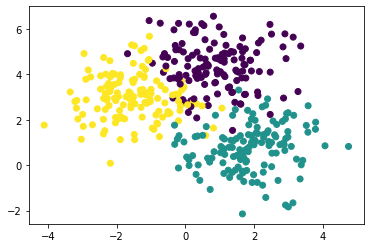

In [19]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

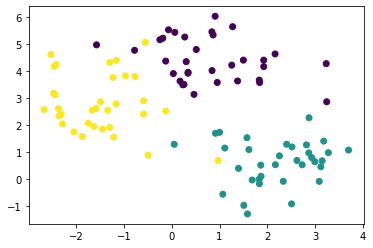

In [20]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)

In [12]:
svm = SVC(probability=True)

In [22]:
svm.fit(X_train, y_train)

SVC(probability=True)

In [24]:
svm.score(X_test, y_test)

0.95

In [26]:
param = [
    {
        "kernel": ["linear"],
        "C": [1, 10, 100, 1000]
    },
    {
        "kernel": ["rbf"],
        "C": [1, 10, 100, 1000],
        "gamma": [1e-2, 1e-3, 1e-4, 1e-5]
    }
]

# request probability estimation
svm = SVC(probability=True)

# 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
clf = GridSearchCV(svm, param,
        cv=10, n_jobs=4, verbose=3)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=4,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']}],
             verbose=3)

In [27]:
clf.best_estimator_

SVC(C=100, gamma=0.01, probability=True)

In [30]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.92      1.00      0.96        34
           2       0.97      0.91      0.94        33

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

